# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression



In [1]:
version  = '23'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_rimedice.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp  = xr.open_dataset(fname).temp.values
    rho   = xr.open_dataset(fname).rho.values
    q_i   = xr.open_dataset(fname).q_rimedice.values
    n_i   = xr.open_dataset(fname).n_rimedice.values
    r_i   = xr.open_dataset(fname).rime_rimedice.values
    v_i   = xr.open_dataset(fname).rvol_rimedice.values
    cwc   = xr.open_dataset(fname).cwc.values
    r_c   = xr.open_dataset(fname).rc.values
    # process rates
    rime_mass  = xr.open_dataset(fname).rime_rimedice_cloud_mass.values
    rime_rmass = xr.open_dataset(fname).rime_rimedice_cloud_rmass.values
    rime_rvol  = xr.open_dataset(fname).rime_rimedice_cloud_rvol.values
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_i = np.log(n_i, where=n_i>n_min, out=np.nan*n_i)
    r_i = np.log(r_i, where=r_i>q_min, out=np.nan*n_i)
    v_i = np.log(v_i, where=v_i>q_min, out=np.nan*n_i)
    q_i = np.log(q_i, where=q_i>q_min, out=np.nan*n_i)
    cwc = np.log(cwc, where=cwc>q_min, out=np.nan*n_i)
    r_c = np.log(r_c, where=r_c>q_min, out=np.nan*n_i)
    rime_mass  = np.log(rime_mass, where=rime_mass>p_min, out=np.nan*rime_mass)
    rime_rmass = np.log(rime_rmass,where=rime_rmass>p_min,out=np.nan*rime_rmass)
    rime_rvol  = np.log(rime_rvol, where=rime_rvol>p_min, out=np.nan*rime_rvol)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_i, n_i, r_i, v_i, cwc, r_c, temp, rho, rime_mass, rime_rmass, rime_rvol ]))
    dataset = dataset.T
    dataset.columns = [ 'q_i', 'n_i', 'r_i', 'v_i', 'cwc', 'r_c', 'temp', 'rho', 'rime_mass', 'rime_rmass', 'rime_rvol' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_i           n_i           r_i           v_i           cwc  \
count  48170.000000  48170.000000  48170.000000  48170.000000  48170.000000   
mean     -12.018214      7.527125    -13.302525    -18.558216     -8.882843   
std        2.387996      2.406966      2.542948      2.549017      1.810547   
min      -23.020565     -5.849514    -26.613077    -31.631765    -25.809702   
25%      -13.359004      6.300625    -14.903391    -20.185254    -10.026786   
50%      -11.922218      7.604272    -13.263840    -18.516157     -8.715644   
75%      -10.401685      9.006622    -11.553010    -16.827546     -7.621105   
max       -5.347612     15.807636     -6.256629    -11.389381     -3.932226   

                r_c          temp           rho     rime_mass    rime_rmass  \
count  48170.000000  48170.000000  48170.000000  48170.000000  48170.000000   
mean     -11.273855    262.965240      0.974664    -20.669657    -20.683266   
std        0.459513      7.197188      0.115701      4.276286      4.269246   
min      -12.203955    246.110001      0.711000    -40.977848    -40.977848   
25%      -11.611741    257.230011      0.881000    -23.265290    -23.274879   
50%      -11.258958    264.450012      0.984000    -20.307619    -20.314131   
75%      -10.928116    268.880005      1.066000    -17.609900    -17.638102   
max      -10.260991    273.140015      1.285000     -9.757336     -9.757336   

          rime_rvol  
count  48170.000000  
mean     -25.978962  
std        4.389341  
min      -46.023853  
25%      -28.629252  
50%      -25.593894  
75%      -22.851504  
max      -14.767970

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_i       n_i        r_i        v_i       cwc        r_c        temp  \
0 -11.834965  7.581669 -16.452967 -21.468021 -8.772085 -12.155304  265.890015   
1 -11.692698  7.744050 -15.343876 -20.366152 -8.859683 -12.155304  265.950012   
3 -11.620110  7.761234 -14.531169 -19.568178 -9.044826 -12.155304  266.079987   
4 -11.591861  7.757564 -14.299613 -19.343794 -9.142682 -12.155304  266.140015   
7 -11.518903  7.741099 -13.861617 -18.927631 -9.465233 -12.155304  266.339996   

     rho  rime_mass  rime_rmass  rime_rvol  
0  1.038 -18.103617  -18.103617 -23.114252  
1  1.039 -18.099026  -18.099026 -23.109659  
3  1.041 -18.241262  -18.241262 -23.251896  
4  1.042 -18.306362  -18.306362 -23.316998  
7  1.046 -18.532379  -18.532379 -23.543015

In [11]:
dataset_train.describe()

q_i           n_i           r_i           v_i           cwc  \
count  33841.000000  33841.000000  33841.000000  33841.000000  33841.000000   
mean     -12.012917      7.533878    -13.295528    -18.551332     -8.879680   
std        2.382541      2.406246      2.536882      2.543327      1.798957   
min      -23.020565     -5.849514    -24.966227    -29.982544    -25.318485   
25%      -13.349452      6.303992    -14.899540    -20.185953    -10.024526   
50%      -11.921329      7.605243    -13.259157    -18.514311     -8.715644   
75%      -10.392878      9.015481    -11.542179    -16.819839     -7.627246   
max       -5.347612     15.807636     -6.307382    -11.599464     -3.932226   

                r_c          temp           rho     rime_mass    rime_rmass  \
count  33841.000000  33841.000000  33841.000000  33841.000000  33841.000000   
mean     -11.272454    262.946320      0.974337    -20.668476    -20.681929   
std        0.459057      7.216786      0.115937      4.262311      4.254462   
min      -12.203955    246.110001      0.711000    -40.977848    -40.977848   
25%      -11.609954    257.190002      0.880000    -23.257435    -23.262398   
50%      -11.256015    264.429993      0.983000    -20.315863    -20.324852   
75%      -10.928116    268.920013      1.066000    -17.615858    -17.645506   
max      -10.260991    273.140015      1.284000    -10.323109    -10.323109   

          rime_rvol  
count  33841.000000  
mean     -25.978460  
std        4.375517  
min      -46.023853  
25%      -28.629816  
50%      -25.598892  
75%      -22.860270  
max      -15.333742

In [12]:
dataset_test.describe()

q_i          n_i          r_i          v_i          cwc  \
count  7212.000000  7212.000000  7212.000000  7212.000000  7212.000000   
mean    -12.024562     7.533125   -13.317680   -18.569857    -8.872603   
std       2.363754     2.368622     2.524961     2.528103     1.819880   
min     -22.997749    -4.659183   -24.576359   -29.595064   -24.864702   
25%     -13.380908     6.295570   -14.921835   -20.174437   -10.031321   
50%     -11.932312     7.596066   -13.298415   -18.545066    -8.703523   
75%     -10.424793     9.003737   -11.575453   -16.858315    -7.585029   
max      -5.859174    15.763461    -6.256629   -11.389381    -4.305066   

               r_c         temp          rho    rime_mass   rime_rmass  \
count  7212.000000  7212.000000  7212.000000  7212.000000  7212.000000   
mean    -11.277366   262.964569     0.974826   -20.654503   -20.667685   
std       0.457049     7.164099     0.115062     4.299587     4.297981   
min     -12.203955   246.160004     0.712000   -39.850834   -39.850834   
25%     -11.611741   257.269989     0.882000   -23.212194   -23.216643   
50%     -11.260433   264.390015     0.984000   -20.225568   -20.226992   
75%     -10.932712   268.799988     1.066000   -17.600316   -17.632367   
max     -10.260991   273.140015     1.273000    -9.955385    -9.955385   

         rime_rvol  
count  7212.000000  
mean    -25.957767  
std       4.417045  
min     -45.763649  
25%     -28.560590  
50%     -25.539667  
75%     -22.825925  
max     -14.966022

In [13]:
dataset_val.describe()

q_i          n_i          r_i          v_i          cwc  \
count  7117.000000  7117.000000  7117.000000  7117.000000  7117.000000   
mean    -12.036963     7.488932   -13.320440   -18.579151    -8.908257   
std       2.438047     2.448558     2.589696     2.596906     1.855480   
min     -22.948057    -5.513096   -26.613077   -31.631765   -25.809702   
25%     -13.373842     6.286929   -14.903539   -20.193403   -10.035877   
50%     -11.916123     7.601952   -13.256866   -18.497627    -8.734106   
75%     -10.419594     8.969326   -11.587143   -16.839622    -7.621105   
max      -5.731812    15.702717    -6.327665   -11.508336    -4.110474   

               r_c         temp          rho    rime_mass   rime_rmass  \
count  7117.000000  7117.000000  7117.000000  7117.000000  7117.000000   
mean    -11.276958   263.056030     0.976054   -20.690622   -20.705406   
std       0.464181     7.137388     0.115226     4.319262     4.310520   
min     -12.203955   246.330002     0.712000   -39.991283   -39.991283   
25%     -11.619475   257.440002     0.884000   -23.380001   -23.392183   
50%     -11.266988   264.600006     0.986000   -20.318415   -20.325611   
75%     -10.924855   268.859985     1.066000   -17.588598   -17.615648   
max     -10.271247   273.140015     1.285000    -9.757336    -9.757336   

         rime_rvol  
count  7117.000000  
mean    -26.002811  
std       4.427150  
min     -45.973537  
25%     -28.708540  
50%     -25.608799  
75%     -22.850235  
max     -14.767970

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_i'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['cwc'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_i           n_i           r_i           v_i           cwc  \
count  33505.000000  33505.000000  33505.000000  33505.000000  33505.000000   
mean     -11.927070      7.621851    -13.218159    -18.472567     -8.864477   
std        2.219357      2.231018      2.415902      2.418125      1.756525   
min      -19.979616     -2.393243    -23.721180    -28.739836    -16.260813   
25%      -13.306646      6.342016    -14.852952    -20.137482    -10.008848   
50%      -11.891993      7.631529    -13.227835    -18.484442     -8.709565   
75%      -10.379043      9.031201    -11.525747    -16.804089     -7.625195   
max       -5.347612     15.807636     -6.307382    -11.599464     -3.932226   

                r_c          temp           rho     rime_mass    rime_rmass  \
count  33505.000000  33505.000000  33505.000000  33505.000000  33505.000000   
mean     -11.271724    262.900146      0.973642    -20.574789    -20.588247   
std        0.459518      7.223239      0.116019      4.149968      4.141953   
min      -12.203955    246.110001      0.711000    -40.977848    -40.977848   
25%      -11.609954    257.119995      0.879000    -23.168941    -23.173660   
50%      -11.255713    264.350006      0.982000    -20.271109    -20.278170   
75%      -10.928116    268.859985      1.066000    -17.593878    -17.614433   
max      -10.260991    273.140015      1.284000    -10.323109    -10.323109   

          rime_rvol  
count  33505.000000  
mean     -25.881611  
std        4.258169  
min      -46.023853  
25%      -28.532442  
50%      -25.551111  
75%      -22.834131  
max      -15.333742

In [17]:
dataset_test.describe()

q_i          n_i          r_i          v_i          cwc  \
count  7141.000000  7141.000000  7141.000000  7141.000000  7141.000000   
mean    -11.936934     7.622350   -13.238065   -18.489506    -8.852793   
std       2.192267     2.185649     2.397087     2.397781     1.771652   
min     -19.978998    -1.889086   -23.670856   -28.683847   -17.052042   
25%     -13.348010     6.334948   -14.862793   -20.127621   -10.008848   
50%     -11.908965     7.627058   -13.266233   -18.513893    -8.685612   
75%     -10.409923     9.014228   -11.560373   -16.841825    -7.579141   
max      -5.859174    15.763461    -6.256629   -11.389381    -4.305066   

               r_c         temp          rho    rime_mass   rime_rmass  \
count  7141.000000  7141.000000  7141.000000  7141.000000  7141.000000   
mean    -11.276545   262.910431     0.973916   -20.555857   -20.568998   
std       0.457915     7.170847     0.115085     4.175645     4.173859   
min     -12.203955   246.160004     0.712000   -39.850834   -39.850834   
25%     -11.611741   257.179993     0.881000   -23.122217   -23.124756   
50%     -11.260433   264.339996     0.983000   -20.180006   -20.185860   
75%     -10.930655   268.750000     1.065000   -17.573603   -17.599585   
max     -10.260991   273.140015     1.273000    -9.955385    -9.955385   

         rime_rvol  
count  7141.000000  
mean    -25.856596  
std       4.289642  
min     -45.763649  
25%     -28.453644  
50%     -25.498419  
75%     -22.804573  
max     -14.966022

### Pairplot

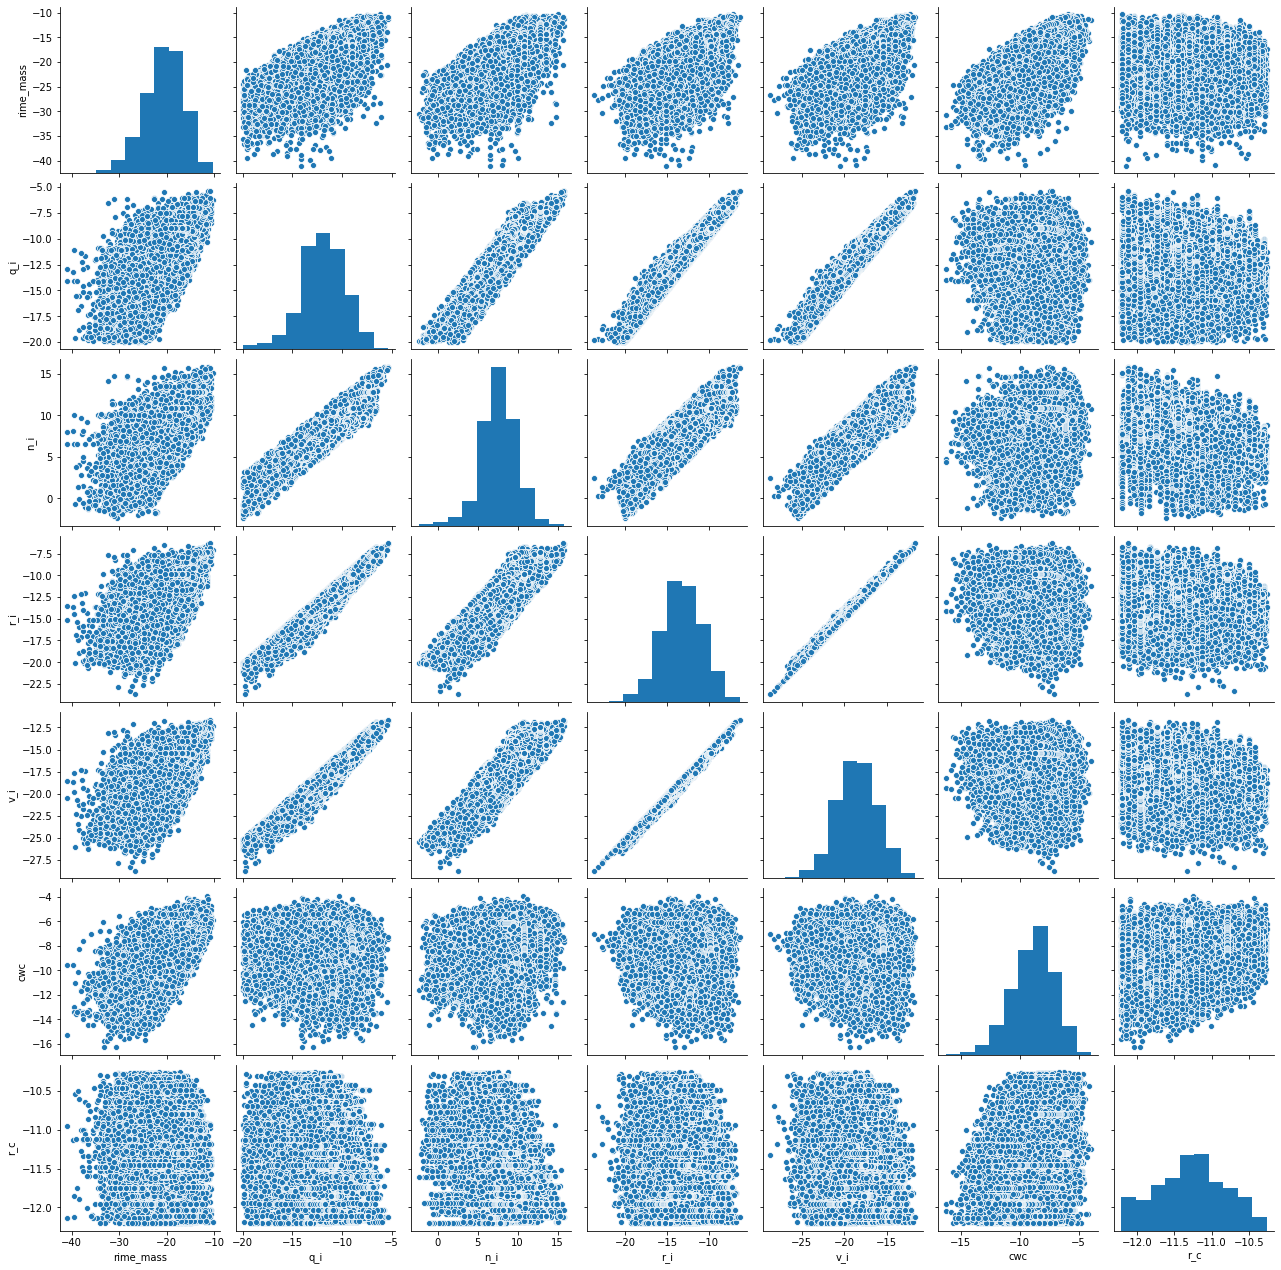

In [18]:
sns.pairplot(dataset_train[["rime_mass","q_i","n_i","r_i","v_i","cwc","r_c"]], diag_kind="hist")

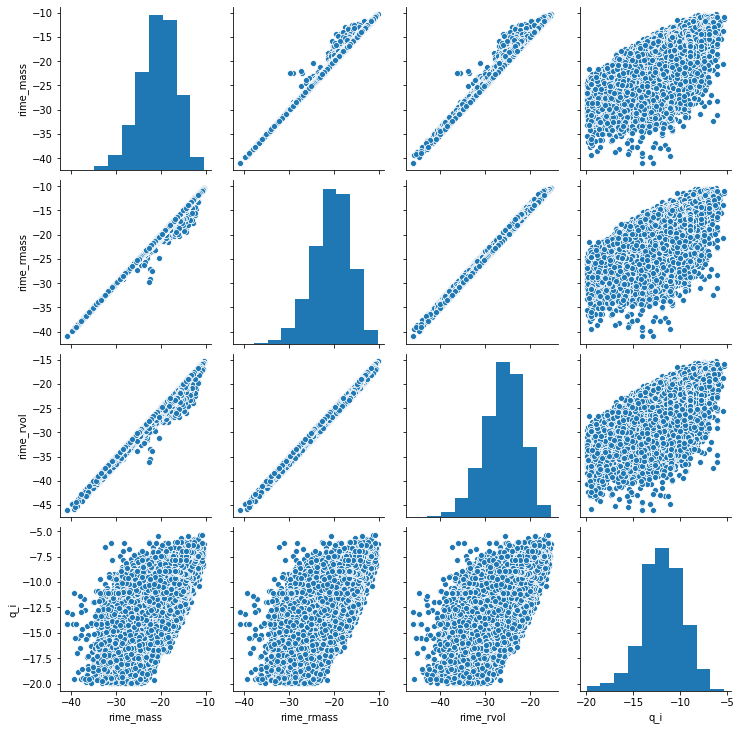

In [19]:
sns.pairplot(dataset_train[["rime_mass","rime_rmass","rime_rvol","q_i"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [21]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [22]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [23]:
train_dataset1 = train_dataset1.drop(['rho'], axis=1)
#train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [24]:
test_dataset1 = test_dataset1.drop(['rho'], axis=1)
#test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [25]:
val_dataset1 = val_dataset1.drop(['rho'], axis=1)
#val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [26]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("rime_mass")
train_stats1.pop("rime_rmass")
train_stats1.pop("rime_rvol")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean       std         min         25%         50%  \
q_i   33505.0  -11.927070  2.219357  -19.979616  -13.306646  -11.891993   
n_i   33505.0    7.621851  2.231018   -2.393243    6.342016    7.631529   
r_i   33505.0  -13.218159  2.415902  -23.721180  -14.852952  -13.227835   
v_i   33505.0  -18.472567  2.418125  -28.739836  -20.137482  -18.484442   
cwc   33505.0   -8.864477  1.756525  -16.260813  -10.008848   -8.709565   
r_c   33505.0  -11.271724  0.459518  -12.203955  -11.609954  -11.255713   
temp  33505.0  262.900146  7.223239  246.110001  257.119995  264.350006   

             75%         max  
q_i   -10.379043   -5.347612  
n_i     9.031201   15.807636  
r_i   -11.525747   -6.307382  
v_i   -16.804089  -11.599464  
cwc    -7.625195   -3.932226  
r_c   -10.928116  -10.260991  
temp  268.859985  273.140015

In [27]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("rime_mass")
train_stats2.pop("rime_rmass")
train_stats2.pop("rime_rvol")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_i   33505.0  -11.927070  2.219357  -19.979616  -13.306646  -11.891993   
n_i   33505.0    7.621851  2.231018   -2.393243    6.342016    7.631529   
r_i   33505.0  -13.218159  2.415902  -23.721180  -14.852952  -13.227835   
v_i   33505.0  -18.472567  2.418125  -28.739836  -20.137482  -18.484442   
cwc   33505.0   -8.864477  1.756525  -16.260813  -10.008848   -8.709565   
r_c   33505.0  -11.271724  0.459518  -12.203955  -11.609954  -11.255713   
temp  33505.0  262.900146  7.223239  246.110001  257.119995  264.350006   
rho   33505.0    0.973642  0.116019    0.711000    0.879000    0.982000   

             75%         max  
q_i   -10.379043   -5.347612  
n_i     9.031201   15.807636  
r_i   -11.525747   -6.307382  
v_i   -16.804089  -11.599464  
cwc    -7.625195   -3.932226  
r_c   -10.928116  -10.260991  
temp  268.859985  273.140015  
rho     1.066000    1.284000

In [28]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("rime_mass")
train_stats3.pop("rime_rmass")
train_stats3.pop("rime_rvol")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_i   33505.0  -11.927070  2.219357  -19.979616  -13.306646  -11.891993   
n_i   33505.0    7.621851  2.231018   -2.393243    6.342016    7.631529   
r_i   33505.0  -13.218159  2.415902  -23.721180  -14.852952  -13.227835   
v_i   33505.0  -18.472567  2.418125  -28.739836  -20.137482  -18.484442   
cwc   33505.0   -8.864477  1.756525  -16.260813  -10.008848   -8.709565   
r_c   33505.0  -11.271724  0.459518  -12.203955  -11.609954  -11.255713   
temp  33505.0  262.900146  7.223239  246.110001  257.119995  264.350006   
rho   33505.0    0.973642  0.116019    0.711000    0.879000    0.982000   

             75%         max  
q_i   -10.379043   -5.347612  
n_i     9.031201   15.807636  
r_i   -11.525747   -6.307382  
v_i   -16.804089  -11.599464  
cwc    -7.625195   -3.932226  
r_c   -10.928116  -10.260991  
temp  268.859985  273.140015  
rho     1.066000    1.284000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['rime_mass','rime_rmass','rime_rvol']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_labels.describe()

rime_mass    rime_rmass     rime_rvol
count  33505.000000  33505.000000  33505.000000
mean     -20.574789    -20.588247    -25.881611
std        4.149968      4.141953      4.258169
min      -40.977848    -40.977848    -46.023853
25%      -23.168941    -23.173660    -28.532442
50%      -20.271109    -20.278170    -25.551111
75%      -17.593878    -17.614433    -22.834131
max      -10.323109    -10.323109    -15.333742

In [33]:
train_dataset1.describe()

q_i           n_i           r_i           v_i           cwc  \
count  33505.000000  33505.000000  33505.000000  33505.000000  33505.000000   
mean     -11.927070      7.621851    -13.218159    -18.472567     -8.864477   
std        2.219357      2.231018      2.415902      2.418125      1.756525   
min      -19.979616     -2.393243    -23.721180    -28.739836    -16.260813   
25%      -13.306646      6.342016    -14.852952    -20.137482    -10.008848   
50%      -11.891993      7.631529    -13.227835    -18.484442     -8.709565   
75%      -10.379043      9.031201    -11.525747    -16.804089     -7.625195   
max       -5.347612     15.807636     -6.307382    -11.599464     -3.932226   

                r_c          temp  
count  33505.000000  33505.000000  
mean     -11.271724    262.900146  
std        0.459518      7.223239  
min      -12.203955    246.110001  
25%      -11.609954    257.119995  
50%      -11.255713    264.350006  
75%      -10.928116    268.859985  
max      -10.260991    273.140015

In [34]:
train_dataset2.describe()

q_i           n_i           r_i           v_i           cwc  \
count  33505.000000  33505.000000  33505.000000  33505.000000  33505.000000   
mean     -11.927070      7.621851    -13.218159    -18.472567     -8.864477   
std        2.219357      2.231018      2.415902      2.418125      1.756525   
min      -19.979616     -2.393243    -23.721180    -28.739836    -16.260813   
25%      -13.306646      6.342016    -14.852952    -20.137482    -10.008848   
50%      -11.891993      7.631529    -13.227835    -18.484442     -8.709565   
75%      -10.379043      9.031201    -11.525747    -16.804089     -7.625195   
max       -5.347612     15.807636     -6.307382    -11.599464     -3.932226   

                r_c          temp           rho  
count  33505.000000  33505.000000  33505.000000  
mean     -11.271724    262.900146      0.973642  
std        0.459518      7.223239      0.116019  
min      -12.203955    246.110001      0.711000  
25%      -11.609954    257.119995      0.879000  
50%      -11.255713    264.350006      0.982000  
75%      -10.928116    268.859985      1.066000  
max      -10.260991    273.140015      1.284000

In [35]:
train_dataset3.describe()

q_i           n_i           r_i           v_i           cwc  \
count  33505.000000  33505.000000  33505.000000  33505.000000  33505.000000   
mean     -11.927070      7.621851    -13.218159    -18.472567     -8.864477   
std        2.219357      2.231018      2.415902      2.418125      1.756525   
min      -19.979616     -2.393243    -23.721180    -28.739836    -16.260813   
25%      -13.306646      6.342016    -14.852952    -20.137482    -10.008848   
50%      -11.891993      7.631529    -13.227835    -18.484442     -8.709565   
75%      -10.379043      9.031201    -11.525747    -16.804089     -7.625195   
max       -5.347612     15.807636     -6.307382    -11.599464     -3.932226   

                r_c          temp           rho  
count  33505.000000  33505.000000  33505.000000  
mean     -11.271724    262.900146      0.973642  
std        0.459518      7.223239      0.116019  
min      -12.203955    246.110001      0.711000  
25%      -11.609954    257.119995      0.879000  
50%      -11.255713    264.350006      0.982000  
75%      -10.928116    268.859985      1.066000  
max      -10.260991    273.140015      1.284000

### Normalize the features

In [36]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [37]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_i   33505.0  2.731762e-07  1.0 -3.628324 -0.621611  0.015805  0.697511   
n_i   33505.0 -6.367874e-09  1.0 -4.489025 -0.573656  0.004338  0.631707   
r_i   33505.0  1.491398e-07  1.0 -4.347454 -0.676680 -0.004005  0.700530   
v_i   33505.0 -4.729452e-07  1.0 -4.245963 -0.688515 -0.004911  0.689988   
cwc   33505.0 -1.666392e-07  1.0 -4.210777 -0.651497  0.088192  0.705531   
r_c   33505.0  1.828725e-06  1.0 -2.028715 -0.736054  0.034844  0.747757   
temp  33505.0 -5.835062e-06  1.0 -2.324462 -0.800216  0.200722  0.825092   

           max  
q_i   2.964578  
n_i   3.669081  
r_i   2.860537  
v_i   2.842327  
cwc   2.807960  
r_c   2.199549  
temp  1.417628

In [38]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_i   33505.0  2.731762e-07  1.0 -3.628324 -0.621611  0.015805  0.697511   
n_i   33505.0 -6.367874e-09  1.0 -4.489025 -0.573656  0.004338  0.631707   
r_i   33505.0  1.491398e-07  1.0 -4.347454 -0.676680 -0.004005  0.700530   
v_i   33505.0 -4.729452e-07  1.0 -4.245963 -0.688515 -0.004911  0.689988   
cwc   33505.0 -1.666392e-07  1.0 -4.210777 -0.651497  0.088192  0.705531   
r_c   33505.0  1.828725e-06  1.0 -2.028715 -0.736054  0.034844  0.747757   
temp  33505.0 -5.835062e-06  1.0 -2.324462 -0.800216  0.200722  0.825092   
rho   33505.0 -7.537021e-07  1.0 -2.263781 -0.815744  0.072040  0.796059   

           max  
q_i   2.964578  
n_i   3.669081  
r_i   2.860537  
v_i   2.842327  
cwc   2.807960  
r_c   2.199549  
temp  1.417628  
rho   2.675060

In [39]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_i   33505.0  2.731762e-07  1.0 -3.628324 -0.621611  0.015805  0.697511   
n_i   33505.0 -6.367874e-09  1.0 -4.489025 -0.573656  0.004338  0.631707   
r_i   33505.0  1.491398e-07  1.0 -4.347454 -0.676680 -0.004005  0.700530   
v_i   33505.0 -4.729452e-07  1.0 -4.245963 -0.688515 -0.004911  0.689988   
cwc   33505.0 -1.666392e-07  1.0 -4.210777 -0.651497  0.088192  0.705531   
r_c   33505.0  1.828725e-06  1.0 -2.028715 -0.736054  0.034844  0.747757   
temp  33505.0 -5.835062e-06  1.0 -2.324462 -0.800216  0.200722  0.825092   
rho   33505.0 -7.537021e-07  1.0 -2.263781 -0.815744  0.072040  0.796059   

           max  
q_i   2.964578  
n_i   3.669081  
r_i   2.860537  
v_i   2.842327  
cwc   2.807960  
r_c   2.199549  
temp  1.417628  
rho   2.675060

### Normalize the labels

In [40]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
rime_mass   33505.0 -20.574789  4.149968 -40.977848 -23.168941 -20.271109   
rime_rmass  33505.0 -20.588247  4.141953 -40.977848 -23.173660 -20.278170   
rime_rvol   33505.0 -25.881611  4.258169 -46.023853 -28.532442 -25.551111   

                  75%        max  
rime_mass  -17.593878 -10.323109  
rime_rmass -17.614433 -10.323109  
rime_rvol  -22.834131 -15.333742

In [41]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [42]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [43]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(7,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 723
Trainable params: 723
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [45]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.68758297, -0.57077646, -0.72616655],
       [-0.6890691 , -0.57390165, -0.729318  ],
       [-0.6896644 , -0.5761843 , -0.73214465],
       [-0.68968886, -0.57682896, -0.7330693 ],
       [-0.6893157 , -0.5780083 , -0.7351277 ],
       [-0.68910295, -0.57826614, -0.7356971 ],
       [-0.6888491 , -0.5784615 , -0.7362155 ],
       [-0.6885638 , -0.5786181 , -0.7367081 ],
       [-0.6878959 , -0.57882535, -0.73763657],
       [-0.6875145 , -0.57887995, -0.73807997]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [46]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [47]:
activ = "ReLU"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2016,  mae:0.2840,  mse:0.2016,  val_loss:0.0881,  val_mae:0.1852,  val_mse:0.0881,  
..............................

Text(0, 0.5, 'MAE')

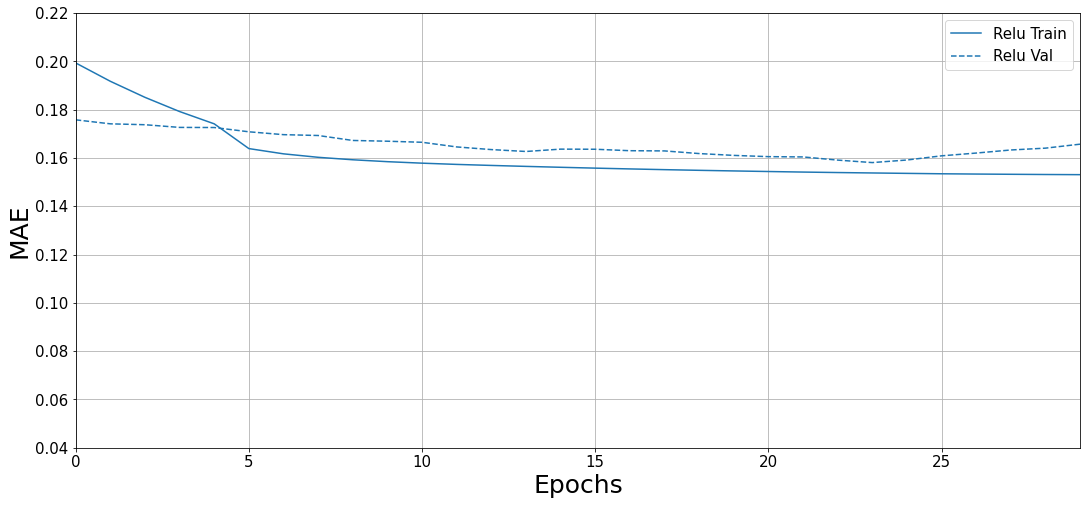

In [48]:
histories['ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.22])
plt.ylabel('MAE')

In [49]:
activ = "ReLU_Adam"
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1850,  mae:0.2799,  mse:0.1850,  val_loss:0.0900,  val_mae:0.1977,  val_mse:0.0900,  
........................................................

Text(0, 0.5, 'MAE')

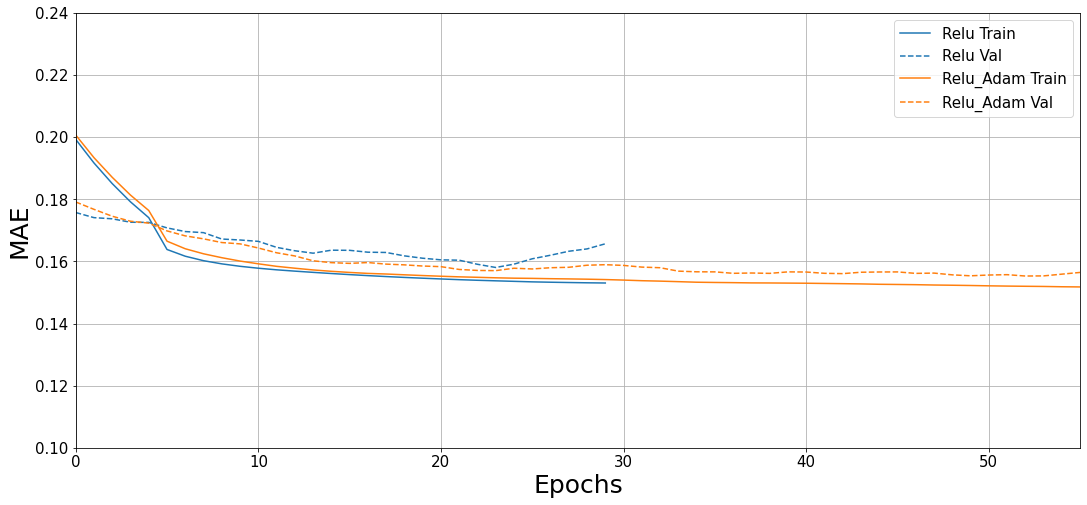

In [50]:
histories['ReLU_Adam'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.24])
plt.ylabel('MAE')

In [51]:
activ = "ReLU"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1565,  mae:0.2649,  mse:0.1565,  val_loss:0.0933,  val_mae:0.1966,  val_mse:0.0933,  
................................................

Text(0, 0.5, 'MAE')

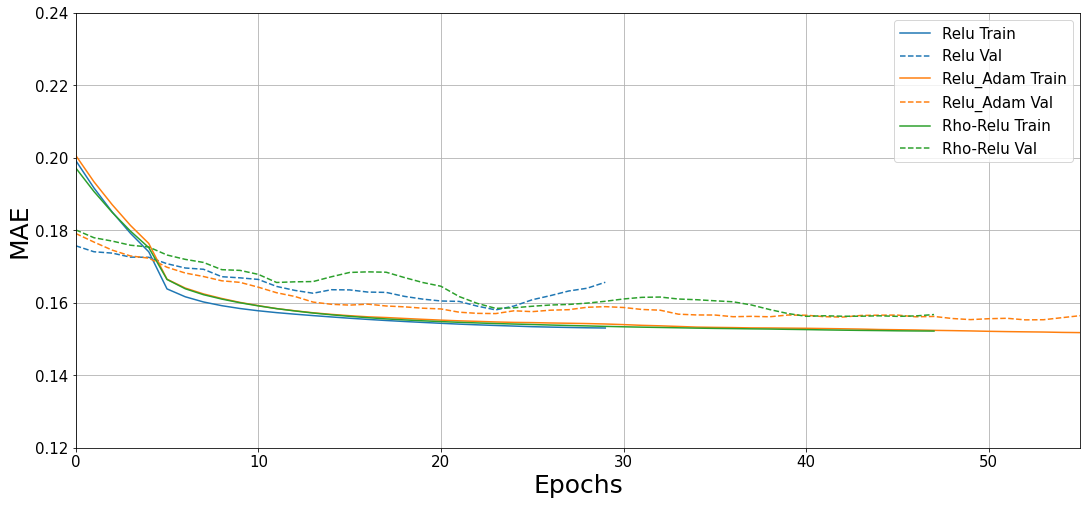

In [52]:
histories['rho-ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.24])
plt.ylabel('MAE')

In [53]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2190,  mae:0.2998,  mse:0.2190,  val_loss:0.0917,  val_mae:0.2006,  val_mse:0.0917,  
........................................................

Text(0, 0.5, 'MAE')

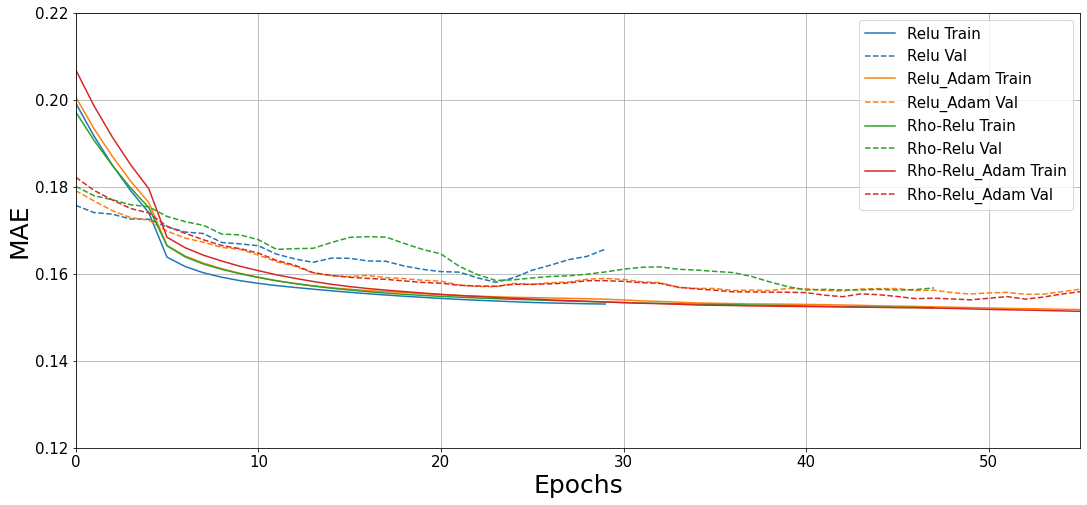

In [54]:
histories['rho-ReLU_Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.22])
plt.ylabel('MAE')

In [55]:
nsize = 32
activ = "ReLU"
model5 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1362,  mae:0.2361,  mse:0.1362,  val_loss:0.0847,  val_mae:0.1795,  val_mse:0.0847,  
..............................................................

Text(0, 0.5, 'MAE')

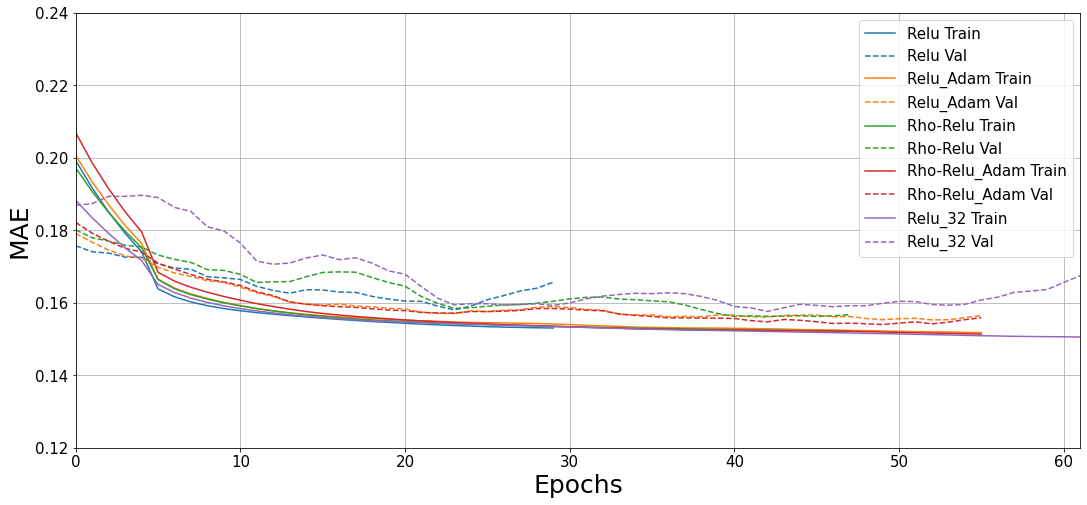

In [56]:
histories['ReLU_32'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.24])
plt.ylabel('MAE')

In [57]:
nsize = 32
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history6 = model6.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1271,  mae:0.2298,  mse:0.1271,  val_loss:0.0877,  val_mae:0.1958,  val_mse:0.0877,  
..............................

Text(0, 0.5, 'MAE')

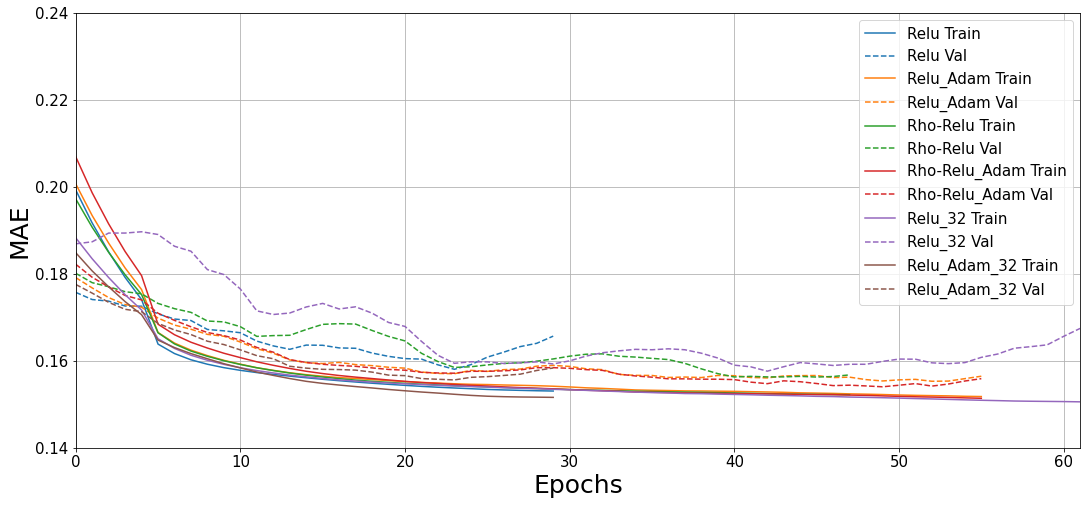

In [60]:
histories['ReLU_Adam_32'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.14, 0.24])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

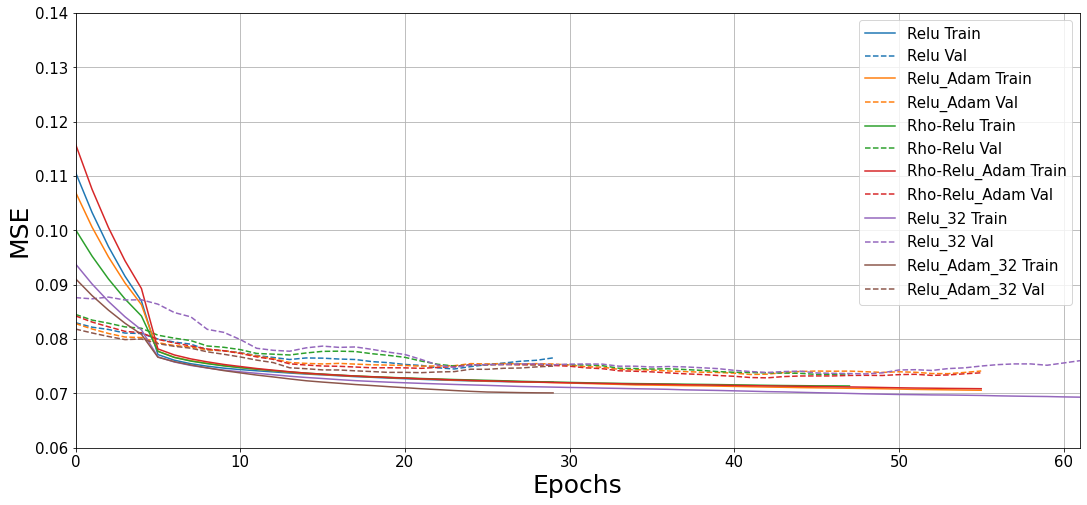

In [61]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.06, 0.14])
plt.ylabel('MSE')

In [62]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

7141/7141 - 0s - loss: 0.0770 - mae: 0.1564 - mse: 0.0770
Testing set for model 1, Mean Abs Error:    0.15641


In [63]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

7141/7141 - 0s - loss: 0.0760 - mae: 0.1550 - mse: 0.0760
Testing set for model 2, Mean Abs Error:              0.15504


In [64]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

7141/7141 - 0s - loss: 0.0773 - mae: 0.1581 - mse: 0.0773
Testing set for model 3, Mean Abs Error:              0.15813


In [65]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

7141/7141 - 0s - loss: 0.0753 - mae: 0.1519 - mse: 0.0753
Testing set for model 4, Mean Abs Error:              0.15194


In [66]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

7141/7141 - 0s - loss: 0.0772 - mae: 0.1571 - mse: 0.0772
Testing set for model 5, Mean Abs Error:              0.15707


In [67]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

7141/7141 - 0s - loss: 0.0752 - mae: 0.1553 - mse: 0.0752
Testing set for model 6, Mean Abs Error:              0.15533


In [68]:
mae = [ mae1, mae2, mae3, mae4, mae5, mae6 ]
mae

[0.15640795, 0.15504113, 0.1581277, 0.1519403, 0.15706989, 0.15533465]

In [69]:
mse = [ mse1, mse2, mse3, mse4, mse5, mse6 ]
mse

[0.07701813, 0.075952776, 0.07726615, 0.075299256, 0.077168345, 0.07520401]

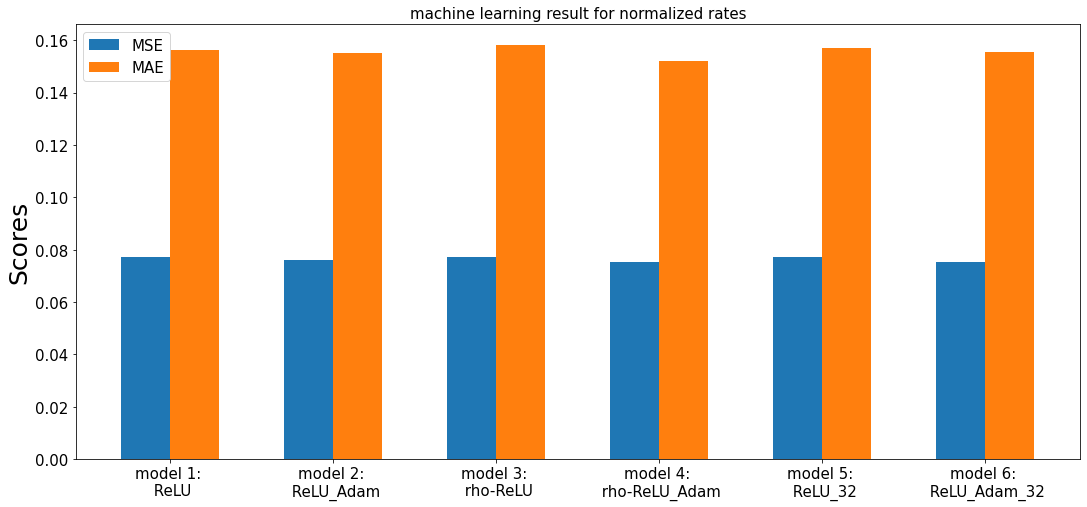

In [70]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1: \n ReLU',
 'model 2: \n ReLU_Adam',
 'model 3: \n rho-ReLU',
 'model 4: \n rho-ReLU_Adam',
 'model 5: \n ReLU_32',
 'model 6: \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [71]:
test_true_rvol  = np.exp(test_labels.pop('rime_rvol'))
test_true_mass = np.exp(test_labels.pop('rime_mass'))

In [72]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [73]:
labels = [ "rime_mass", "rime_rmass", "rime_rvol" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=labels)

In [74]:
p1.describe()

rime_mass   rime_rmass    rime_rvol
count  7141.000000  7141.000000  7141.000000
mean      0.015536     0.018754     0.027123
std       0.971256     0.971545     0.970303
min      -3.243833    -3.237833    -3.392950
25%      -0.672210    -0.664474    -0.646076
50%       0.075419     0.074760     0.078639
75%       0.723438     0.729968     0.732477
max       2.542197     2.546022     2.530257

In [75]:
train_labels_stats

count       mean       std        min        25%        50%  \
rime_mass   33505.0 -20.574789  4.149968 -40.977848 -23.168941 -20.271109   
rime_rmass  33505.0 -20.588247  4.141953 -40.977848 -23.173660 -20.278170   
rime_rvol   33505.0 -25.881611  4.258169 -46.023853 -28.532442 -25.551111   

                  75%        max  
rime_mass  -17.593878 -10.323109  
rime_rmass -17.614433 -10.323109  
rime_rvol  -22.834131 -15.333742

In [76]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [77]:
test_predict1.describe()

rime_mass    rime_rmass     rime_rvol
count  7.141000e+03  7.141000e+03  7.141000e+03
mean   1.997143e-07  1.938361e-07  1.253463e-09
std    1.219846e-06  1.169678e-06  8.125843e-09
min    1.652327e-15  1.715281e-15  3.056182e-18
25%    7.127756e-11  7.300677e-11  3.672587e-13
50%    1.586391e-09  1.559978e-09  8.038702e-12
75%    2.335286e-08  2.353553e-08  1.301154e-10
max    4.428987e-05  4.350020e-05  2.747653e-07

In [78]:
np.exp(test_dataset1.head())

q_i          n_i           r_i           v_i       cwc       r_c  \
6   0.000010  2316.100342  8.495099e-07  5.397599e-09  0.000087  0.000005   
11  0.000011  2244.200195  1.306800e-06  8.001303e-09  0.000047  0.000005   
14  0.000011  2204.200439  1.489200e-06  8.901496e-09  0.000030  0.000005   
16  0.000012  2179.700195  1.576200e-06  9.264093e-09  0.000021  0.000005   
37  0.000014  1954.600220  3.467000e-06  2.039400e-08  0.000178  0.000005   

    temp  
6    inf  
11   inf  
14   inf  
16   inf  
37   inf

In [79]:
test_predict1.head()

rime_mass    rime_rmass     rime_rvol
0  7.769802e-09  8.047996e-09  4.875131e-11
1  3.504236e-09  3.650818e-09  2.374795e-11
2  2.350479e-09  2.338417e-09  1.586475e-11
3  1.473408e-09  1.347830e-09  9.104511e-12
4  3.307248e-08  3.482631e-08  2.450957e-10

In [80]:
test_dataset2.head()

q_i       n_i        r_i        v_i        cwc        r_c  \
6  -11.541376  7.747640 -13.978606 -19.037312  -9.354211 -12.155304   
11 -11.440140  7.716105 -13.547929 -18.643661  -9.963238 -12.155304   
14 -11.393100  7.698120 -13.417272 -18.537046 -10.410985 -12.155304   
16 -11.366231  7.686943 -13.360494 -18.497120 -10.766237 -12.155304   
37 -11.152388  7.577941 -12.572221 -17.708025  -8.633727 -12.155304   

          temp    rho  
6   266.279999  1.044  
11  266.619995  1.051  
14  266.829987  1.054  
16  266.980011  1.057  
37  268.519989  1.085

In [81]:
test_predict1_rvol  = test_predict1['rime_rvol']
test_predict1_mass = test_predict1['rime_mass']

In [82]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_rvol = test_predict2['rime_rvol']
test_predict2_mass = test_predict2['rime_mass']


In [83]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_rvol = test_predict3['rime_rvol']
test_predict3_mass = test_predict3['rime_mass']


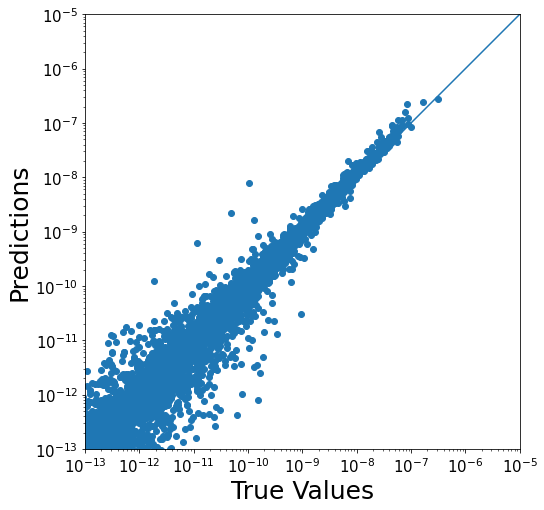

In [84]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-13, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_rvol, test_predict1_rvol)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

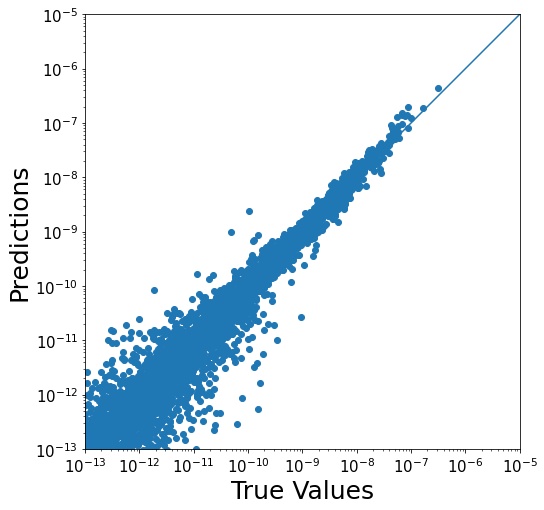

In [85]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_rvol, test_predict2_rvol)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

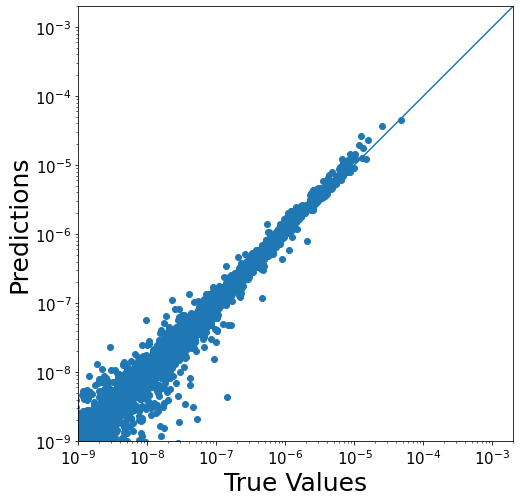

In [86]:
amin, amax = 1e-9, 2e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

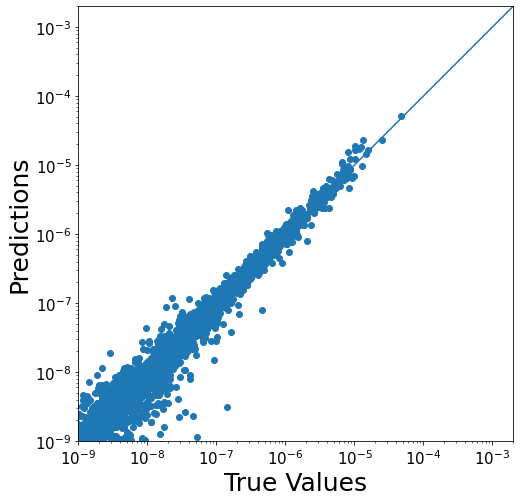

In [87]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

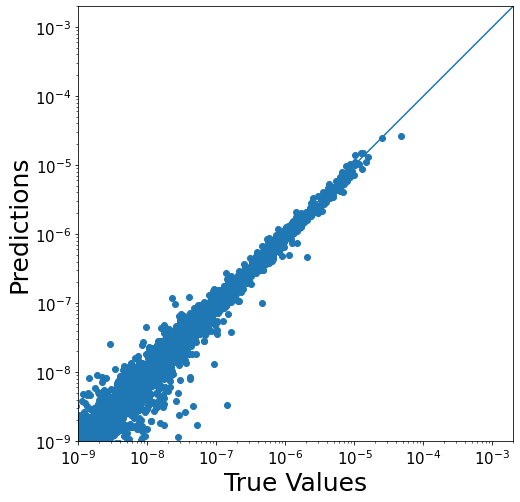

In [88]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [89]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [90]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [91]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T'
labels   = 'rime_rimedice_cloud_mass, rime_rimedice_cloud_rmass, rime_rimedice_cloud_rvol'
filename = 'saved_model_v2/rime_rimedice_cloud_model1_'+version+'.nc'

logtransform = np.array([True, True, True, True, True, True, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_rimedice_cloud_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_rimedice_cloud_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_rimedice_cloud_model6_'+version+'.nc'
save2netcdf(model6,features,labels,train_stats1,train_labels_stats,logtransform,filename)


Saving model to saved_model_v2/rime_rimedice_cloud_model1_23.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T
  Labels:     rime_rimedice_cloud_mass, rime_rimedice_cloud_rmass, rime_rimedice_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 3), Activation: linear
Saving model to saved_model_v2/rime_rimedice_cloud_model2_23.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T
  Labels:     rime_rimedice_cloud_mass, rime_rimedice_cloud_rmass, rime_rimedice_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), 

In [92]:
train_stats1

count        mean       std         min         25%         50%  \
q_i   33505.0  -11.927070  2.219357  -19.979616  -13.306646  -11.891993   
n_i   33505.0    7.621851  2.231018   -2.393243    6.342016    7.631529   
r_i   33505.0  -13.218159  2.415902  -23.721180  -14.852952  -13.227835   
v_i   33505.0  -18.472567  2.418125  -28.739836  -20.137482  -18.484442   
cwc   33505.0   -8.864477  1.756525  -16.260813  -10.008848   -8.709565   
r_c   33505.0  -11.271724  0.459518  -12.203955  -11.609954  -11.255713   
temp  33505.0  262.900146  7.223239  246.110001  257.119995  264.350006   

             75%         max  
q_i   -10.379043   -5.347612  
n_i     9.031201   15.807636  
r_i   -11.525747   -6.307382  
v_i   -16.804089  -11.599464  
cwc    -7.625195   -3.932226  
r_c   -10.928116  -10.260991  
temp  268.859985  273.140015

In [93]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T, rho'
labels   = 'rime_rimedice_cloud_mass, rime_rimedice_cloud_rmass, rime_rimedice_cloud_rvol'
logtransform = np.array([True, True, True, True, True, True, False, False], dtype=bool)


filename = 'saved_model_v2/rime_rimedice_cloud_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_rimedice_cloud_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/rime_rimedice_cloud_model3_23.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T, rho
  Labels:     rime_rimedice_cloud_mass, rime_rimedice_cloud_rmass, rime_rimedice_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 3), Activation: linear
Saving model to saved_model_v2/rime_rimedice_cloud_model4_23.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T, rho
  Labels:     rime_rimedice_cloud_mass, rime_rimedice_cloud_rmass, rime_rimedice_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, 

In [94]:
train_stats2

count        mean       std         min         25%         50%  \
q_i   33505.0  -11.927070  2.219357  -19.979616  -13.306646  -11.891993   
n_i   33505.0    7.621851  2.231018   -2.393243    6.342016    7.631529   
r_i   33505.0  -13.218159  2.415902  -23.721180  -14.852952  -13.227835   
v_i   33505.0  -18.472567  2.418125  -28.739836  -20.137482  -18.484442   
cwc   33505.0   -8.864477  1.756525  -16.260813  -10.008848   -8.709565   
r_c   33505.0  -11.271724  0.459518  -12.203955  -11.609954  -11.255713   
temp  33505.0  262.900146  7.223239  246.110001  257.119995  264.350006   
rho   33505.0    0.973642  0.116019    0.711000    0.879000    0.982000   

             75%         max  
q_i   -10.379043   -5.347612  
n_i     9.031201   15.807636  
r_i   -11.525747   -6.307382  
v_i   -16.804089  -11.599464  
cwc    -7.625195   -3.932226  
r_c   -10.928116  -10.260991  
temp  268.859985  273.140015  
rho     1.066000    1.284000